In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Streaming output truncated to the last 5000 lines.
It: 35001, Total Loss: 1.424e-03, Loss_residue: 1.018e-05, Loss_measurements: 8.710e-04 Time: 0.01, L1: 1059.927, L2: 2.580
It: 35002, Total Loss: 7.354e-04, Loss_residue: 1.097e-05, Loss_measurements: 5.831e-04 Time: 0.01, L1: 1059.927, L2: 2.580
It: 35003, Total Loss: 2.862e-03, Loss_residue: 1.086e-05, Loss_measurements: 3.817e-04 Time: 0.01, L1: 1059.927, L2: 2.580
It: 35004, Total Loss: 2.294e-03, Loss_residue: 1.532e-05, Loss_measurements: 9.467e-04 Time: 0.01, L1: 1059.927, L2: 2.580
It: 35005, Total Loss: 4.387e-04, Loss_residue: 1.215e-05, Loss_measurements: 2.742e-04 Time: 0.01, L1: 1059.927, L2: 2.580
It: 35006, Total Loss: 1.285e-03, Loss_residue: 1.427e-05, Loss_measurements: 3.104e-04 Time: 0.01, L1: 1059.927, L2: 2.580
It: 35007, Total Loss: 2.099e-03, Loss_residue: 1.685e-05, Loss_measurements: 7.938e-04 Time: 0.01, L1: 1059.927, L2: 2.580
It: 35008, Total Loss: 8.140e-04, Loss_residue: 1.314e-05, Loss_measurements: 2.9

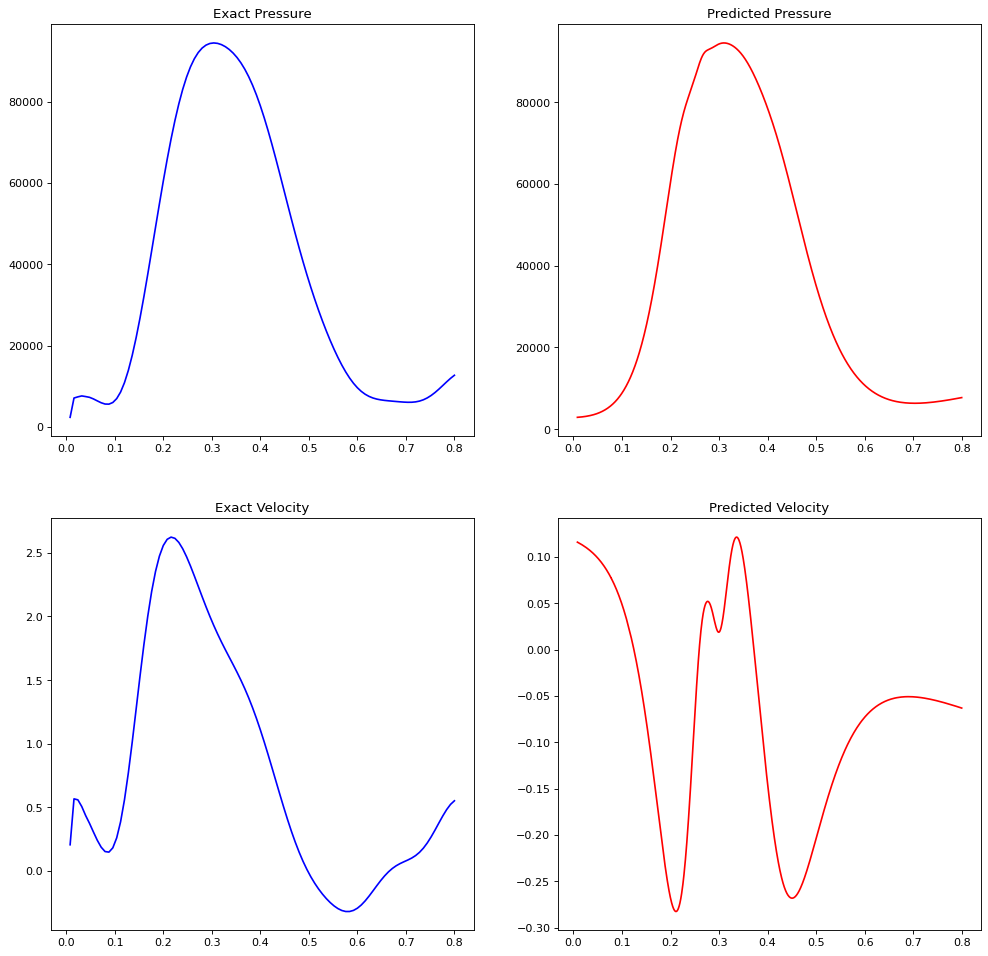

In [17]:
import tensorflow as tf
import numpy as np
import timeit
import matplotlib.pyplot as plt
import numpy as np
# tf.compact.v1.enable_eager_execution()

class OneDBioPINN:
    # Initialize the class
    def __init__(self, X_measurement_vessel1, 
                p_training_vessel1,
                X_residual_vessel1,  
                T_residual, T_measurement, 
                X_interface, T1_interface,
                T2_interface, layers, bif_points):
        
        self.A_01 = 1.35676200E-05 

        self.pi = np.pi
        # self.rho = 1000.0
        self.beta1 =  69673881.97

        self.lambda_1 = tf.Variable([1060], dtype=tf.float32) # 1060
        self.lambda_2 = tf.Variable([3.5], dtype=tf.float32) # 3.5
                
        self.U = 1e+1  

        self.L = np.sqrt(1*(self.A_01))
        self.T = self.L/self.U
        self.p0 = self.lambda_1*self.U**2   

        self.A0 = self.L**2

        X_measurement_vessel1 = X_measurement_vessel1/self.L
        X_residual_vessel1 = X_residual_vessel1/self.L
        X_interface = X_interface/self.L
        
        T_residual  = T_residual/self.T
        T_measurement  = T_measurement/self.T
        T1_interface = T1_interface/self.T
        T2_interface = T2_interface/self.T
                
        # Normalize inputs
        self.Xmean1, self.Xstd1 = X_residual_vessel1.mean(0), X_residual_vessel1.std(0)

        self.Tmean, self.Tstd = T_residual.mean(0), T_residual.std(0)
        
        self.jac_x1 = 1.0/self.Xstd1

        self.jac_t = 1.0/self.Tstd
        

        self.X_f1 = (X_residual_vessel1 - self.Xmean1)/self.Xstd1
        self.X_u1 = (X_measurement_vessel1 - self.Xmean1)/self.Xstd1

        self.X_i = (X_interface - self.Xmean1)/self.Xstd1
        

        self.T_u = (T_measurement - self.Tmean)/self.Tstd
        self.T_f = (T_residual - self.Tmean)/self.Tstd
        self.T1_i = (T1_interface - self.Tmean)/self.Tstd
        self.T2_i = (T2_interface - self.Tmean)/self.Tstd
        
        self.layers = layers
        
        X1_fm = bif_points/self.L

        bif_p1 = (X1_fm - self.Xmean1)/self.Xstd1
        
        X1max = bif_p1[0]

        self.p_u1 = p_training_vessel1 
        
        # Initialize network weights and biases        
        self.weights1, self.biases1 = self.initialize_NN(layers)
                        
        # Define placeholders and computational graph
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        
        self.X1_fm = tf.constant([X1max], shape = [1024,1], dtype=tf.float32)
        
        self.t_bound = tf.placeholder(tf.float32, shape=(None, self.T_f.shape[1]), name='self.t_bound')
                
        self.X_u_tf1 = tf.placeholder(tf.float32, shape=(None, self.X_u1.shape[1]),name= 'self.X_u_tf1')
        
        self.t_u_tf = tf.placeholder(tf.float32,  shape=(None, self.T_u.shape[1]), name='self.t_u_tf')

        self.X_f_tf1 = tf.placeholder(tf.float32, shape=(None, self.X_f1.shape[1]),name= 'self.X_f_tf1')

        self.t_f_tf = tf.placeholder(tf.float32, shape=(None, self.T_f.shape[1]), name='self.t_f_tf')

        self.p_u_tf1 = tf.placeholder(tf.float32, shape=(None, self.p_u1.shape[1]),name= 'self.X_u_tf1')

        self.X_i_tf = tf.placeholder(tf.float32, shape=(None, self.X_i.shape[1]),name= 'self.X1_i_tf')

        self.t1_i_tf = tf.placeholder(tf.float32, shape=(None, self.T1_i.shape[1]),name= 'self.t1_i_tf')

        self.t2_i_tf = tf.placeholder(tf.float32, shape=(None, self.T2_i.shape[1]), name='self.t2_i_tf')


        # predictions
               
        self.A_u_pred1, self.u_u_pred1, self.p_u_pred1  = self.neural_net_vessel1(self.X_u_tf1, self.t_u_tf)

        self.A_f_pred1, self.u_f_pred1, self.p_f_pred1  = self.neural_net_vessel1(self.X_f_tf1, self.t_f_tf)

        self.A1_i_pred1, self.u1_i_pred1, self.p1_i_pred1  = self.neural_net_vessel1(self.X_i_tf, self.t1_i_tf)

        self.A2_i_pred1, self.u2_i_pred1, self.p2_i_pred1  = self.neural_net_vessel1(self.X_i_tf, self.t2_i_tf)
   
        self.r_A1  = self.pinn_vessel1(self.X_f_tf1, self.t_f_tf)

        self.loss_p1 = self.compute_measurement_loss_vessel1(self.p_u_pred1)
        self.loss_r = self.compute_residual_loss_vessel1 (self.r_A1)
        self.loss_i = self.compute_interface_loss()
                      
        self.loss_measurements = self.loss_p1

        self.loss_residual = self.loss_r
       
        self.loss =  self.loss_residual + self.loss_measurements + self.loss_i
        
        # Define optimizer        
        self.optimizer  = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        config = tf.ConfigProto(log_device_placement=True)
        self.sess = tf.Session(config=config)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
       
           
    def neural_net(self, H, weights, biases, layers):
        num_layers = len(layers)  
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_vessel1(self, x, t):
        Au = self.neural_net(tf.concat([x,t],1),self.weights1,self.biases1,self.layers)
        A = Au[:,0:1]
        u = Au[:,1:2]
        p = Au[:,2:3]
        return tf.exp(A), u, p
     
    def pinn_vessel1(self, x, t):

        l1 = self.lambda_1
        l2 = self.lambda_2
        
        A, u, p = self.neural_net_vessel1(x,t) # \hat{A}, \hat{u}, \hat{p}
        
        # r_p  =  self.beta1*(tf.sqrt(A*self.A0) - tf.sqrt(self.A_01)) 
        
        p_x = tf.gradients(p, x)[0]*self.jac_x1

        # A_t = tf.gradients(A, t)[0]*self.jac_t
        # A_x = tf.gradients(A, x)[0]*self.jac_x1
        
        u_t = tf.gradients(u, t)[0]*self.jac_t
        u_x = tf.gradients(u, x)[0]*self.jac_x1
        u_xx = tf.gradients(u_x, x)[0]*self.jac_x1
                
        # r_A = A_t + u*A_x + A*u_x #r_A*
        # r_u = u_t + 0.11*u*u*u_x + (0.1*u*u*A_x)/A + p_x/l1 + (22*l2*self.pi*u)/A #r_u*

        r = u_t + l1*u*u_x - p_x - l2*u_xx
        
        return r
    
    def compute_residual_loss_vessel1(self, r_A):
                                   
        loss_rA = tf.reduce_mean(tf.square(r_A)) 
        
        return  loss_rA


    def compute_measurement_loss_vessel1(self, p_u):
    
        loss_p = tf.reduce_mean(tf.square((self.p_u1 - p_u*self.p0)/self.p0))

        return loss_p

    def compute_interface_loss(self):

        l1 = self.lambda_1
         
        Q1 = self.A1_i_pred1*self.u1_i_pred1
        Q2 = self.A2_i_pred1*self.u2_i_pred1
        
        loss_mass = tf.reduce_mean(tf.square((Q1 - Q2))) 
        
        p_1 = self.p1_i_pred1 + (0.5*l1*self.u1_i_pred1**2)
        p_2 = self.p2_i_pred1 + (0.5*l1*self.u2_i_pred1**2)
        
        loss_press = tf.reduce_mean(tf.square( p_1 - p_2))
                            
        return  loss_mass + loss_press

    
    def fetch_minibatch(self, X1_f, t_f, N_f_batch):        
        N_f = X1_f.shape[0]
        idx_f = np.random.choice(N_f, N_f_batch, replace=False)
        X1_f_batch = X1_f[idx_f,:]
        t_f_batch = t_f[idx_f,:]  

        return  X1_f_batch, t_f_batch
             
    # Trains the model by minimizing the MSE loss
    def train(self, nIter = 20000, learning_rate = 1e-3): 
        
    
        start_time = timeit.default_timer()
        for it in range(nIter):
            
            X1_f_batch, T_f_batch = \
                    self.fetch_minibatch(self.X_f1, self.T_f,\
                                         N_f_batch = 1024)

#            print(type(tf.Session().run(self.X_u1)))  
                                
            self.T_f_b = T_f_batch
        # Define a dictionary for associating placeholders with data
            tf_dict = {self.X_u_tf1: self.X_u1, 
                       self.X_f_tf1: X1_f_batch,
                       self.t_f_tf:  T_f_batch, 
                       self.t_u_tf:  self.T_u,
                       self.p_u_tf1: self.p_u1,
                       self.X_i_tf: self.X_i,
                       self.t1_i_tf: self.T1_i,
                       self.t2_i_tf: self.T2_i,
                       self.learning_rate: learning_rate}

                 
            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)
            
            # Print
            if it % 1 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value, loss_r, loss_m, l1, l2 = self.sess.run([self.loss,
                                                            self.loss_residual,
                                                            self.loss_measurements,
                                                            self.lambda_1,
                                                            self.lambda_2], tf_dict)
    
                print('It: %d, Total Loss: %.3e, Loss_residue: %.3e, Loss_measurements: %.3e Time: %.2f, L1: %.3f, L2: %.3f' % 
                      (it, loss_value, loss_r, loss_m, elapsed, l1, l2))
                start_time = timeit.default_timer()
              
                               
    # Evaluates predictions at test points           
    def predict_vessel1(self, X1, t): 

        X1 = X1/self.L
        t  = t/self.T
        
        X1 = (X1 - self.Xmean1)/self.Xstd1
        t = (t - self.Tmean)/self.Tstd
        
        tf_dict1 = {self.X_f_tf1: X1, self.t_f_tf: t}    
       
        A_star1 = self.sess.run(self.A_f_pred1, tf_dict1) 
        u_star1 = self.sess.run(self.u_f_pred1, tf_dict1) 
        p_star1 = self.sess.run(self.p_f_pred1, tf_dict1) 
                
        A_star1 = A_star1*self.A0
        u_star1 = u_star1*self.U
        p_star1 = p_star1*self.p0
        p_star1 = p_star1.eval(session=self.sess)
              
        return A_star1, u_star1, p_star1


if __name__ == "__main__":
    N_f =  5000
    
    input_vessel_1 = np.load("input_1.npy",allow_pickle=True).item()
    t_i = input_vessel_1["Time"][:,None]
    t = t_i[t_i<=0.8][:,None]
    
    test_vessel_1 = np.load("test_1.npy",allow_pickle=True).item()

    velocity_measurements_vessel1 = input_vessel_1["Velocity"][:,None]
    velocity_measurements_vessel1 = velocity_measurements_vessel1[t_i<=0.8][:,None]
    
    area_measurements_vessel1 = input_vessel_1["Area"][:,None]
    area_measurements_vessel1 = area_measurements_vessel1[t_i<=0.8][:,None]
        
    velocity_test_vessel1 = test_vessel_1["Velocity"][:,None]
    velocity_test_vessel1 = velocity_test_vessel1[t_i<=0.8][:,None]

    pressure_test_vessel1 = test_vessel_1["Pressure"][:,None]
    pressure_test_vessel1 = pressure_test_vessel1[t_i<=0.8][:,None]

    N_u = t.shape[0]
    N_i = 1000
    
    layers = [2, 100, 100, 100, 100, 100, 100, 100, 3]   
    
    lower_bound_t = t.min(0)
    upper_bound_t = t.max(0)
    
    lower_bound_vessel_1 = 0.0   
    upper_bound_vessel_1 = 0.1703
    
    bif_points = 0.1703
    
    X_initial_vessel1 = np.linspace(lower_bound_vessel_1,upper_bound_vessel_1,N_u)[:,None]
    
    T_initial  = lower_bound_t*np.ones((N_u))[:,None]
    
    X_boundary_vessel1 = 0.1*np.ones((N_u))[:,None]

    T_boundary = t
        
    X_measurement_vessel1 = np.vstack((X_initial_vessel1, X_boundary_vessel1))    
    
    T_measurement = np.vstack((T_initial, T_boundary))

    X_residual_vessel1 = lower_bound_vessel_1 + (upper_bound_vessel_1-lower_bound_vessel_1)*np.random.random((N_f))[:,None]
    
    T_residual = lower_bound_t + (upper_bound_t-lower_bound_t)*np.random.random((N_f))[:,None]

    X_interface = np.linspace(lower_bound_vessel_1,upper_bound_vessel_1,N_i)[:,None]

    T1_interface = lower_bound_t*np.ones((N_i))[:,None]
    T2_interface = upper_bound_t*np.ones((N_i))[:,None]


    p_min = pressure_test_vessel1.min()
    p_initial_vessel1 = p_min*np.ones((N_u,1))
        
    p_training_vessel1 = np.vstack((p_initial_vessel1,pressure_test_vessel1))
              
    model = OneDBioPINN(X_measurement_vessel1, 
                        p_training_vessel1,
                        X_residual_vessel1,  
                        T_residual, T_measurement, 
                        X_interface, T1_interface, T2_interface,
                        layers, bif_points)

    model.train(nIter = 20000, learning_rate = 1e-3)
    model.train(nIter = 40000, learning_rate = 1e-4)
    # model.train(5000,0.05)
    # model.train(500,0.001)
            
    X_test_vessel1 = 0.1*np.ones((T_residual.shape[0],1))
    T_residual = np.sort(T_residual, 0)
        
    A_predicted_vessel1, U_predicted_vessel1, p_predicted_vessel1  = model.predict_vessel1(X_test_vessel1, T_residual)
    # print(type(U_predicted_vessel1))
    print(type(p_predicted_vessel1))
    # print(p_predicted_vessel1.numpy())

    from matplotlib.pyplot import figure

    figure(figsize=(15, 15), dpi=80)
    plt.subplot(2,2,1)
    plt.plot(t,pressure_test_vessel1, linestyle = '-', color='blue', label='Exact pressure')
    plt.title("Exact Pressure")
    # plt.savefig('exact_pressure.jpeg')
    # plt.clf()
    plt.subplot(2,2,2)
    plt.plot(T_residual,p_predicted_vessel1, linestyle = '-', color='red', label='Predicted pressure')
    plt.title("Predicted Pressure")
    # plt.savefig('predicted_pressure.jpeg')
    # plt.clf()
    plt.subplot(2,2,3)
    plt.plot(t,velocity_test_vessel1, linestyle = '-', color='blue', label='Exact velocity')
    plt.title("Exact Velocity")
    # plt.savefig('exact_velocity.jpeg')
    # plt.clf()
    plt.subplot(2,2,4)
    plt.plot(T_residual,U_predicted_vessel1, linestyle = '-', color='red', label='Predicted velocity')
    plt.title("Predicted Velocity")
    plt.savefig('predicted_exact.jpeg')
    plt.show()